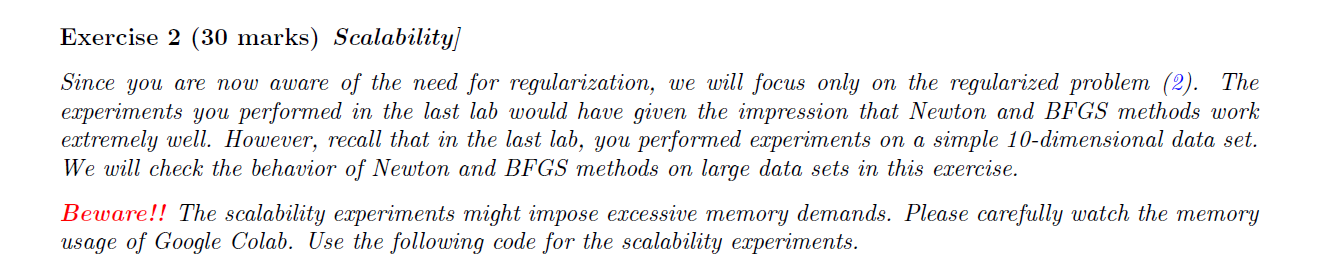

In [1]:
# Code for BFGS method
import numpy as np
import matplotlib.pyplot as plt
import math
import timeit

np.random.seed(1000)  #for repeatability

In [2]:
# define the function
def evalf(x,lam,A):
  assert type(x) is np.ndarray   #assert type(x) is expected_type, you are checking if the type of the variable x matches the expected_type
  fval = np.linalg.norm(np.matmul(A,x) - y)
  fval = 0.5 * (fval)**2+(lam/2)*np.matmul(x.T,x)
  return (fval)

#gradient of the function
def evalg(x,lam,A):
  assert type(x) is np.ndarray
  grad=(lam*x+np.matmul(A.T, np.matmul(A, x) - y))
  return grad

#hussian of the function
def evalh(x,lam,A):
  assert type(x) is np.ndarray
  return np.matmul(A.T,A)+lam*np.identity(d)

In [3]:
#define the b_k for the BFGS algorithm
def compute_B_k(s, y, B_k):
  I=np.identity(ds[i])
  assert type(s) is np.ndarray
  assert type(y) is np.ndarray
  assert type(B_k) is np.ndarray
  mu = 1 / np.dot(np.squeeze(np.asarray(y)), np.squeeze(np.asarray(s)))
  c1 = np.outer(np.multiply(mu, s), np.transpose(y))
  c2 = np.outer(np.multiply(mu, y), np.transpose(s))
  a = np.subtract(I, c1)
  b = np.subtract(I, c2)
  c = np.outer(np.multiply(mu, s), np.transpose(s))
  d = np.matmul(np.matmul(a, B_k), b)
  pk = np.add(d, c)
  return pk

In [4]:
#line search type
EXACT_LINE_SEARCH = 0
BACKTRACKING_LINE_SEARCH = 1

In [5]:
#here we compute the d_k for the backtracking the line  search algorithm
def compute_D_k(x):
  assert type(x) is np.ndarray
  pk = evalh(x,A)
  return np.linalg.inv(pk)

In [6]:
def compute_steplength_backtracking_scaled_direction(x, lam,gradf, alpha_start, rho, gamma, B_k):  #implement the  backtracking_scaled_direction algorithm
  assert type(x) is np.ndarray
  assert type(gradf) is np.ndarray
  assert type(alpha_start) is float and alpha_start>=0.
  assert type(rho) is float and rho>=0.
  assert type(gamma) is float and gamma>=0.
  alpha = alpha_start
  pr = - gradf
  D_k = B_k

  while evalf(x + alpha*np.matmul(D_k,pr),lam,A) > evalf(x,lam,A) + gamma * alpha* (np.matmul(np.matrix.transpose(gradf), np.matmul(D_k,pr)) ):
    alpha = alpha * rho
  return alpha


$ Algorithm $  $ Newton's Method $



Require: Starting point $\mathbf{x}_{\mathbf{0}}$, Stopping tolerance $\tau$ \\
$1: Initialize  :  $k=0


$2: while \left\|\nabla f\left(\mathbf{x}_{\mathbf{k}}\right)\right\|_{2}>\tau$ do :


3: $\quad \mathbf{x}_{\mathbf{k}+\mathbf{1}} \leftarrow \mathbf{x}_{\mathbf{k}}-\left(\nabla^{2} f\left(\mathbf{x}_{\mathbf{k}}\right)\right)^{-1} \nabla f\left(\mathbf{x}_{\mathbf{k}}\right)$ \\
4: $\quad k \leftarrow k+1$ \\
5: Output: $\mathbf{x}_{\mathbf{k}}$ \\


In [7]:
def minimizer_Newtonmethod(start_x,A,lam, tol, line_search_type, *args):  #using the newton  algorithm
  assert type(start_x) is np.ndarray
  assert type(tol) is float and tol>=0

  x = start_x
  g_x = evalg(x,lam,A)
  h_x = evalh(x,lam,A)

  if line_search_type == BACKTRACKING_LINE_SEARCH:
    if args is None:
      err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive any args. Please check!'
      raise ValueError(err_msg)
    elif len(args)<3 :
      err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive three args. Please check!'
      raise ValueError(err_msg)
    else:
      alpha_start = float(args[0])
      rho = float(args[1])
      gamma = float(args[2])
  k = 0
  x_array_newton = []
  f_array_newton = []
  while (np.linalg.norm(g_x) > tol):
    D_k = np.linalg.inv(evalh(x,lam,A))
    if line_search_type == BACKTRACKING_LINE_SEARCH:
      step_length = compute_steplength_backtracking_scaled_direction(x,lam, g_x, alpha_start, rho, gamma, D_k)
    else:
      raise ValueError('Line search type unknown. Please check!')
    x = np.subtract(x, np.multiply(step_length,np.matmul(D_k, g_x)))
    k = k + 1
    g_x = evalg(x,lam,A)
  return x,  k, x_array_newton, f_array_newton

In [8]:
def minimizer_BFGS(start_x,A, lam,tol, line_search_type, *args):  # now implement the BFGS algorithm
  assert type(start_x) is np.ndarray
  assert type(tol) is float and tol>=0

  x = start_x
  g_x = evalg(x,lam,A)

  if line_search_type == BACKTRACKING_LINE_SEARCH:
    if args is None:
      err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive any args. Please check!'
      raise ValueError(err_msg)
    elif len(args)<3 :
      err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive three args. Please check!'
      raise ValueError(err_msg)
    else:
      alpha_start = float(args[0])
      rho = float(args[1])
      gamma = float(args[2])

  k = 0
  B_k = np.identity(d)
  x_old = x
  x_array_bfgs = []
  f_array_bfgs = []
  while (np.linalg.norm(g_x) > tol):
    if line_search_type == BACKTRACKING_LINE_SEARCH:
      step_length = compute_steplength_backtracking_scaled_direction(x_old,lam, g_x, alpha_start, rho, gamma, B_k)
    else:
      raise ValueError('Line search type unknown. Please check!')
    x_new = np.subtract(x_old, np.multiply(step_length, np.matmul(B_k,g_x)))
    g_x = evalg(x_new,lam,A)
    s = np.subtract(x_new, x_old)
    y = np.subtract(evalg(x_new,lam,A), evalg(x_old,lam,A))
    B_k = compute_B_k(s, y, B_k)
    x_old = x_new
    k = k + 1
  return x_new, k, x_array_bfgs, f_array_bfgs

In [9]:

alpha = 0.99
rho = 0.5
gamma = 0.5
my_tol = 1e-5
N = 200
ds = [1000, 5000, 10000, 20000, 25000, 50000, 100000, 200000, 500000, 1000000]
lam = 0.001

k1 = []
eps = np.random.randn(N, 1)

for i in range(np.size(ds)):
    d = ds[i]
    A = np.random.randn(N, d)
    x = np.ones((d, 1))
    y = np.dot(A, x) + eps

    start = timeit.default_timer()
    x, k, x_array_newton, f_array_newton = minimizer_Newtonmethod(x.reshape((d, 1)), A, lam, my_tol, BACKTRACKING_LINE_SEARCH, alpha, rho, gamma)
    end = timeit.default_timer()

    k1.append(end - start)
    print('Iteration:', i+1)
    print('The total CPU time taken for column value', ds[i], 'is', end - start)
    print('The minimizer for column value', ds[i], 'is', np.array(x))
    print('L2 for column value', ds[i], 'is', x - np.ones((d, 1)))
    print('\n')

print(k1)


Iteration: 1
The total CPU time taken for column value 1000 is 0.5948630429999966
The minimizer for column value 1000 is [[-0.10658915]
 [ 0.23769531]
 [ 0.03595899]
 [ 0.90608289]
 [-0.70716937]
 [-0.13130891]
 [ 0.0734809 ]
 [ 0.07671791]
 [ 0.40284539]
 [ 0.29497489]
 [ 0.42756293]
 [ 0.16968614]
 [-0.19138188]
 [ 0.91682663]
 [ 0.42760756]
 [ 0.28184065]
 [-0.36283019]
 [ 0.2432029 ]
 [ 0.61909738]
 [-0.13323161]
 [-0.23701899]
 [-0.27810263]
 [-0.81304211]
 [ 0.15953103]
 [-0.40622116]
 [-0.24617601]
 [-0.4355604 ]
 [ 0.60177243]
 [ 0.38553254]
 [ 0.00449235]
 [-0.05165505]
 [-0.61878159]
 [-0.47148702]
 [-0.77287553]
 [ 0.06739768]
 [ 0.35128311]
 [ 0.4772769 ]
 [ 0.51061653]
 [-0.67787982]
 [ 0.32497826]
 [-0.34573853]
 [-0.29696098]
 [-0.39877703]
 [-0.0293918 ]
 [ 0.37251076]
 [ 0.75077114]
 [-0.81879697]
 [-0.27379417]
 [ 0.56042783]
 [-0.01148626]
 [ 0.38028693]
 [-0.01194584]
 [ 0.34066312]
 [ 0.42468984]
 [ 0.66760345]
 [ 0.39669492]
 [ 0.44791904]
 [-0.34447018]
 [ 0.5377

KeyboardInterrupt: 

**comment:**

The failure for newton's method occurs at the dimension 20000 and take the lot of time .

In [10]:
import numpy as np


In [ ]:
alpha = 0.99   #we take the alpha from the previous lab
rho = 0.5   # use α0 = 0.99, ρ = 0.5, γ = 0.5  and τ = 10−5
rho = 0.5
gamma = 0.5
my_tol= 1e-5
N=200
ds=[1000,5000,10000,20000,25000,50000,100000,200000,500000,1000000]
lam=0.001   #lambda_reg = 0.001

k1=[]
eps = np.random.randn(N,1)
for i in range(np.size(ds)):
  d=ds[i]
  A=np.random.randn(N,d)
  x=np.ones((d,1))
  y=np.dot(A,x)+eps
  start=timeit.default_timer()
  x, k, x_array_newton, f_array_newton = minimizer_BFGS(x.reshape((d,1)),A,lam, my_tol, BACKTRACKING_LINE_SEARCH, alpha, rho, gamma)
  end=timeit.default_timer()
  k1.append(end-start)
  print('The CPU time taken for column value',ds[i],'is',end-start)
  print('The minimizer for column value',ds[i],'is',np.array(x))
  print('L2 for column value',ds[i],'is',x-np.ones((d,1)))
print(k1)

The CPU time taken for column value 1000 is 27.911932393
The minimizer for column value 1000 is [[ 2.18805889e-01]
 [ 3.65563552e-01]
 [ 1.33778590e-01]
 [ 3.66196709e-01]
 [ 8.06484348e-01]
 [-3.68989178e-01]
 [ 3.43273361e-01]
 [-3.69900498e-01]
 [-1.44213715e-01]
 [ 3.16917891e-01]
 [ 5.00494638e-01]
 [-9.63416200e-02]
 [-5.11182240e-01]
 [-7.27589407e-01]
 [ 3.33796637e-01]
 [ 1.50883400e-01]
 [-3.08032813e-02]
 [-7.63970999e-02]
 [ 1.40780908e+00]
 [-4.37331833e-01]
 [ 8.65202847e-01]
 [ 1.69959328e-01]
 [ 7.53994308e-01]
 [-4.08998160e-01]
 [-1.20840630e-01]
 [-6.30175292e-01]
 [ 2.82959006e-01]
 [-1.14904583e-01]
 [ 3.41142763e-01]
 [ 7.86329948e-01]
 [-3.52943509e-01]
 [-5.86864460e-01]
 [ 3.75387252e-01]
 [-4.20934311e-01]
 [-3.20870910e-01]
 [-1.65869767e-01]
 [ 2.35737488e-01]
 [-3.97069915e-01]
 [ 1.54911175e-01]
 [ 2.46927707e-01]
 [-2.03342711e-01]
 [-3.62789009e-01]
 [ 5.54672863e-02]
 [ 3.65272430e-01]
 [ 5.45588599e-01]
 [ 6.71005554e-01]
 [ 2.47310017e-01]
 [-3.055221

Here The system ran for more than 40 minutes,Hence the failure occur  for column no. 5000.